In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_path = "/Users/amirgazar/Documents/GitHub/Decarbonization-Tradeoffs/1 Decarbonization Pathways/Decarbonization_Pathways.xlsx"

# Read all sheets into a dictionary
all_sheets = pd.read_excel(file_path, sheet_name=None)

# List to hold DataFrames
df_list = []

# Iterate over each sheet
for sheet_name, df in all_sheets.items():
    df['Pathway'] = sheet_name  # Add the 'Pathway' column
    df_list.append(df)

# Concatenate all DataFrames into one
decarb_pathways = pd.concat(df_list, ignore_index=True)

# ── A) MANUAL CANADIAN HYDRO INJECTION (ONLY FOR B3) ───────────────────
b3_hydro_map = {
    2025: 0,
    2050: 3692.308
}
decarb_pathways['Canadian Hydro'] = 0.0
mask_b3 = decarb_pathways['Pathway'] == 'B3'
decarb_pathways.loc[mask_b3, 'Canadian Hydro'] = (
    decarb_pathways.loc[mask_b3, 'Year']
                 .map(b3_hydro_map)
                 .fillna(0)
)

techs = [
    'Solar',
    'Onshore Wind',
    'Offshore Wind',
    'Imports QC',
    'Imports NYISO',
    'Canadian Hydro',
    'SMR',
    'New NG'
]
colors = {
    "Solar":         "#FBE7A1",
    "Onshore Wind":  "#B4D6E3",
    "Offshore Wind": "#A9CAD6",
    "Imports QC":    "#D1B1D6",
    "Imports NYISO": "#F4B6C2",
    "Canadian Hydro":"#9EB1D4",
    "SMR":           "#EFD9B4",
    "New NG":        "#E9967A"
}

# ── C) COMPUTE Δha FOR 2024→2050 ────────────────────────────────────────
baseline, target = decarb_pathways['Year'].min(), 2050
df0 = decarb_pathways.query("Year==@baseline").set_index('Pathway')
df1 = decarb_pathways.query("Year==@target").set_index('Pathway')
cap_diff  = df1[techs] - df0[techs]

In [3]:
cap_diff

,Solar,Onshore Wind,Offshore Wind,Imports QC,Imports NYISO,Canadian Hydro,SMR,New NG
Pathway,,,,,,,,
A,0,0,0,0.0,0.0,0.000,0,0
B1,64281,12045,32643,4100.0,1600.0,0.000,0,0
B2,64281,12045,41593,0.0,1600.0,0.000,0,0
B3,64281,12045,28524,6000.0,1600.0,3692.308,0,0
C1,0,0,0,0.0,0.0,0.000,42000,0
C2,64281,12045,32643,0.0,1600.0,0.000,4200,0
C3,64281,12045,28524,4100.0,1600.0,0.000,2100,0
D,14185,5082,1530,4100.0,1600.0,0.000,0,20358


In [4]:
import pandas as pd
import numpy as np

# ── YOUR ΔCAPACITY DATA ──────────────────────────────────────────────────
# (assumes you already have cap_diff from your previous code)
# cap_diff = df1[techs] - df0[techs]

# ── IMPACT METRICS ────────────────────────────────────────────────────────
impact = {
    'Onshore Wind': {
        'birds_per_mw_yr': np.mean([4, 11]),
        'bats_per_mw_yr':  np.mean([12, 19])
    },
    'Offshore Wind': {
        'birds_per_turbine_yr': 0.017,
        'bats_per_turbine_yr':  0.0
    },
    'Solar': {
        'birds_per_mw_yr': np.mean([1.8, 2.5])
    },
    'Canadian Hydro': {
        'fish_mortality_rate_per_pass': 0.22
    }
}

# ── OFFSHORE/SOLAR/HYDRO PARAMETERS ───────────────────────────────────────
avg_offshore_turbine_capacity_mw = 5.0
fish_passages_per_mw_yr = 100_000

# ── TRANSMISSION ASSUMPTION ───────────────────────────────────────────────
total_grid_capacity_mw = 1_100_000  # MW of U.S. high-voltage network (approx)
impact['Transmission'] = {
    'birds_per_mw_yr': np.mean([8e6, 57e6]) / total_grid_capacity_mw
}

# ── CALCULATION ──────────────────────────────────────────────────────────
species_deaths = pd.DataFrame(index=cap_diff.index)

# Onshore wind
species_deaths['Onshore_bird_deaths'] = (
    cap_diff['Onshore Wind'] * impact['Onshore Wind']['birds_per_mw_yr']
)
species_deaths['Onshore_bat_deaths'] = (
    cap_diff['Onshore Wind'] * impact['Onshore Wind']['bats_per_mw_yr']
)

# Offshore wind
num_turbines = cap_diff['Offshore Wind'] / avg_offshore_turbine_capacity_mw
species_deaths['Offshore_bird_deaths'] = (
    num_turbines * impact['Offshore Wind']['birds_per_turbine_yr']
)
species_deaths['Offshore_bat_deaths'] = (
    num_turbines * impact['Offshore Wind']['bats_per_turbine_yr']
)

# Solar PV
species_deaths['Solar_bird_deaths'] = (
    cap_diff['Solar'] * impact['Solar']['birds_per_mw_yr']
)

# Canadian hydro (fish)
species_deaths['Hydro_fish_passages'] = (
    cap_diff['Canadian Hydro'] * fish_passages_per_mw_yr
)
species_deaths['Hydro_fish_deaths'] = (
    species_deaths['Hydro_fish_passages'] * impact['Canadian Hydro']['fish_mortality_rate_per_pass']
)

# Transmission (imports)
trans_rate = impact['Transmission']['birds_per_mw_yr']
species_deaths['Trans_QC_bird_deaths'] = (
    cap_diff['Imports QC'] * trans_rate
)
species_deaths['Trans_NYISO_bird_deaths'] = (
    cap_diff['Imports NYISO'] * trans_rate
)
species_deaths['Trans_total_bird_deaths'] = (
    species_deaths['Trans_QC_bird_deaths'] +
    species_deaths['Trans_NYISO_bird_deaths']
)

# ── OUTPUT ────────────────────────────────────────────────────────────────
print("Estimated species mortality by pathway (2024→2050 Δ):")
display(species_deaths)



Estimated species mortality by pathway (2024→2050 Δ):


,Onshore_bird_deaths,Onshore_bat_deaths,Offshore_bird_deaths,Offshore_bat_deaths,Solar_bird_deaths,Hydro_fish_passages,Hydro_fish_deaths,Trans_QC_bird_deaths,Trans_NYISO_bird_deaths,Trans_total_bird_deaths
Pathway,,,,,,,,,,
A,0.0,0.0,0.0000,0.0,0.00,0.0,0.0,0.000000,0.000000,0.000000
B1,90337.5,186697.5,110.9862,0.0,138204.15,0.0,0.0,121136.363636,47272.727273,168409.090909
B2,90337.5,186697.5,141.4162,0.0,138204.15,0.0,0.0,0.000000,47272.727273,47272.727273
B3,90337.5,186697.5,96.9816,0.0,138204.15,369230800.0,81230776.0,177272.727273,47272.727273,224545.454545
C1,0.0,0.0,0.0000,0.0,0.00,0.0,0.0,0.000000,0.000000,0.000000
C2,90337.5,186697.5,110.9862,0.0,138204.15,0.0,0.0,0.000000,47272.727273,47272.727273
C3,90337.5,186697.5,96.9816,0.0,138204.15,0.0,0.0,121136.363636,47272.727273,168409.090909
D,38115.0,78771.0,5.2020,0.0,30497.75,0.0,0.0,121136.363636,47272.727273,168409.090909


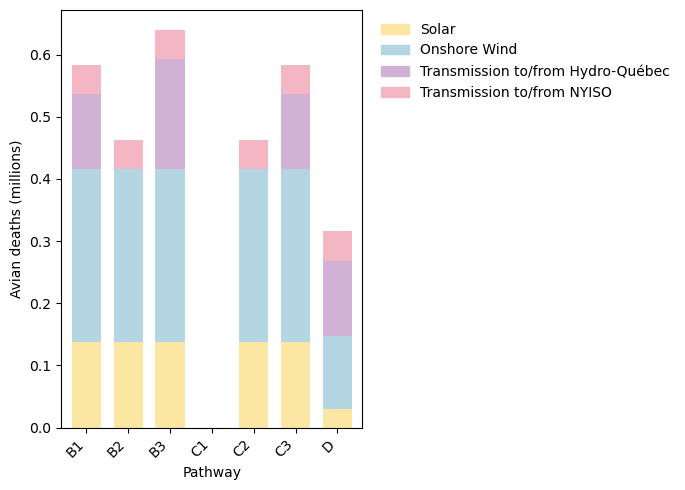

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# ── 1) BUILD PER-PATHWAY TOTAL DEATHS BY TECH ─────────────────────────────
death_mapping = {
    'Solar':         ['Solar_bird_deaths'],
    'Onshore Wind':  ['Onshore_bird_deaths', 'Onshore_bat_deaths'],
    'Offshore Wind': [],
    'Imports QC':    ['Trans_QC_bird_deaths'],
    'Imports NYISO': ['Trans_NYISO_bird_deaths'],
    'Canadian Hydro': [],  # excluded → zeros
    'SMR':            [],  # excluded → zeros
    'New NG':         []   # excluded → zeros
}

deaths_by_tech = pd.DataFrame(index=species_deaths.index)
for tech, cols in death_mapping.items():
    deaths_by_tech[tech] = species_deaths[cols].sum(axis=1) if cols else 0.0

# ── 2) EXCLUDE PATHWAY A & DROP ZERO-ONLY TECHS ──────────────────────────
df = deaths_by_tech.drop(index='A', errors='ignore')
# keep only techs where sum across pathways > 0
nonzero_cols = df.columns[df.sum(axis=0) > 0]
df = df[nonzero_cols]

# ── 3) SCALE TO MILLIONS ──────────────────────────────────────────────────
df_mill = df / 1e6

# ── 4) PLOT STACKED BAR CHART ─────────────────────────────────────────────
colors = {
    "Solar":         "#FBE7A1",
    "Onshore Wind":  "#B4D6E3",
    "Offshore Wind": "#A9CAD6",
    "Imports QC":    "#D1B1D6",
    "Imports NYISO": "#F4B6C2"
}
legend_mapping = {
    "Solar":        "Solar",
    "Onshore Wind": "Onshore Wind",
    "Offshore Wind":"Offshore Wind",
    "Imports QC":   "Transmission to/from Hydro-Québec",
    "Imports NYISO":"Transmission to/from NYISO"
}

fig, ax = plt.subplots(figsize=(8, 5))
df_mill.plot(
    kind='bar',
    stacked=True,
    color=[colors[t] for t in df_mill.columns],
    ax=ax,
    figsize=(7, 5),
    width=0.7
)

ax.set_ylabel('Avian deaths (millions)')
ax.set_xticklabels(df_mill.index, rotation=45, ha='right')

handles = [
    Patch(color=colors[t], label=legend_mapping[t])
    for t in df_mill.columns
]
ax.legend(
    handles=handles,
    loc='upper left',
    bbox_to_anchor=(1.02, 1),
    frameon=False
)

plt.tight_layout()
plt.savefig('avian_deaths.png', dpi=300,
            bbox_inches='tight', pad_inches=0.1)
plt.show()


In [8]:
import pandas as pd
import numpy as np

# ── assume you already have cap_diff = df1[techs] – df0[techs]

# ── 1) DEFINE DISTRIBUTIONS FROM TABLE ──────────────────────────────────
# Onshore Wind: Gamma(shape, loc, scale)
# Solar:       Lognormal(mean=log(1.214), sigma=1.409)
# Offshore & Hydro remain fixed as before

dist_params = {
    'Onshore Wind': {
        'birds_per_mw_yr': ('gamma',      0.20, 0.0, 2.54),
        'bats_per_mw_yr':  ('gamma',    1.538, 0.0, 4.160),
    },
    'Solar': {
        'birds_per_mw_yr': ('lognormal', np.log(1.214), 1.409),
    },
    # fallback to your previous fixed values:
    'Offshore Wind': {
        'birds_per_turbine_yr': 0,
        'bats_per_turbine_yr':  0.0,
    },
    'Canadian Hydro': {
        'fish_mortality_rate_per_pass': 0
    }
}

avg_offshore_turbine_capacity_mw = 5.0
fish_passages_per_mw_yr = 100_000

# ── 2) SAMPLE ONE DRAW FOR EACH METRIC ─────────────────────────────────
sampled = {}
for tech, metrics in dist_params.items():
    for key, spec in metrics.items():
        if isinstance(spec, tuple):
            if spec[0] == 'gamma':
                _, shape, loc, scale = spec
                sampled[(tech, key)] = np.random.gamma(shape, scale) + loc
            elif spec[0] == 'lognormal':
                _, mu, sigma = spec
                sampled[(tech, key)] = np.random.lognormal(mu, sigma)
        else:
            # fixed value
            sampled[(tech, key)] = spec

# ── 3) COMPUTE SPECIES MORTALITY ────────────────────────────────────────
species_deaths = pd.DataFrame(index=cap_diff.index)

# Onshore Wind
b_rate = sampled[('Onshore Wind','birds_per_mw_yr')]
bat_rate = sampled[('Onshore Wind','bats_per_mw_yr')]
species_deaths['Onshore_bird_deaths'] = cap_diff['Onshore Wind'] * b_rate
species_deaths['Onshore_bat_deaths']  = cap_diff['Onshore Wind'] * bat_rate

# Offshore Wind
n_turbines = cap_diff['Offshore Wind'] / avg_offshore_turbine_capacity_mw
species_deaths['Offshore_bird_deaths'] = (
    n_turbines * sampled[('Offshore Wind','birds_per_turbine_yr')]
)
species_deaths['Offshore_bat_deaths'] = (
    n_turbines * sampled[('Offshore Wind','bats_per_turbine_yr')]
)

# Solar PV
s_rate = sampled[('Solar','birds_per_mw_yr')]
species_deaths['Solar_bird_deaths'] = cap_diff['Solar'] * s_rate

# Canadian Hydro (fish)
pass_rate = fish_passages_per_mw_yr
mort_rate = sampled[('Canadian Hydro','fish_mortality_rate_per_pass')]
species_deaths['Hydro_fish_passages'] = cap_diff['Canadian Hydro'] * pass_rate
species_deaths['Hydro_fish_deaths']   = (
    species_deaths['Hydro_fish_passages'] * mort_rate
)

# Transmission imports (treat like onshore)
trans_rate = sampled[('Onshore Wind','birds_per_mw_yr')]  # or define separately
species_deaths['Trans_QC_bird_deaths']   = cap_diff['Imports QC'] * trans_rate
species_deaths['Trans_NYISO_bird_deaths'] = cap_diff['Imports NYISO'] * trans_rate
species_deaths['Trans_total_bird_deaths'] = (
    species_deaths['Trans_QC_bird_deaths']
  + species_deaths['Trans_NYISO_bird_deaths']
)

# ── 4) OUTPUT ───────────────────────────────────────────────────────────
print("Sampled mortality rates (bird/bat per MW∙yr, fish mortality per pass):")
for (tech,key), val in sampled.items():
    print(f"  {tech:15s} {key:30s} = {val:.3f}")

print("\nEstimated species mortality by pathway (Δ 2024→2050):")
display(species_deaths)


Sampled mortality rates (bird/bat per MW∙yr, fish mortality per pass):
  Onshore Wind    birds_per_mw_yr                = 0.198
  Onshore Wind    bats_per_mw_yr                 = 2.310
  Solar           birds_per_mw_yr                = 1.318
  Offshore Wind   birds_per_turbine_yr           = 0.000
  Offshore Wind   bats_per_turbine_yr            = 0.000
  Canadian Hydro  fish_mortality_rate_per_pass   = 0.000

Estimated species mortality by pathway (Δ 2024→2050):


,Onshore_bird_deaths,Onshore_bat_deaths,Offshore_bird_deaths,Offshore_bat_deaths,Solar_bird_deaths,Hydro_fish_passages,Hydro_fish_deaths,Trans_QC_bird_deaths,Trans_NYISO_bird_deaths,Trans_total_bird_deaths
Pathway,,,,,,,,,,
A,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
B1,2389.633863,27825.488139,0.0,0.0,84722.475697,0.0,0.0,813.407957,317.427495,1130.835452
B2,2389.633863,27825.488139,0.0,0.0,84722.475697,0.0,0.0,0.000000,317.427495,317.427495
B3,2389.633863,27825.488139,0.0,0.0,84722.475697,369230800.0,0.0,1190.353107,317.427495,1507.780603
C1,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
C2,2389.633863,27825.488139,0.0,0.0,84722.475697,0.0,0.0,0.000000,317.427495,317.427495
C3,2389.633863,27825.488139,0.0,0.0,84722.475697,0.0,0.0,813.407957,317.427495,1130.835452
D,1008.229082,11740.068968,0.0,0.0,18695.855972,0.0,0.0,813.407957,317.427495,1130.835452


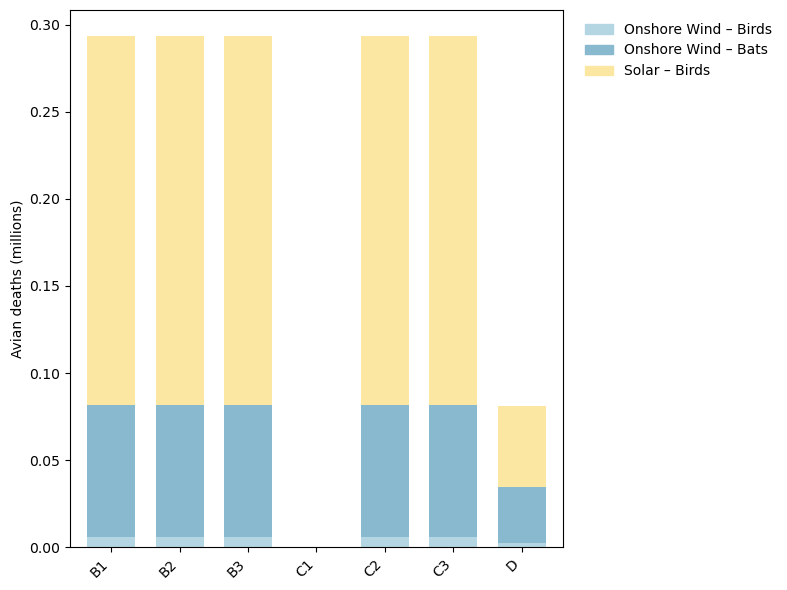

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ── assume cap_diff = df1[techs] - df0[techs] is already defined ──────────

# 1) Monte Carlo settings & pathways
np.random.seed(42)
n_sims   = 1000
pathways = [p for p in cap_diff.index if p != 'A']
n_paths  = len(pathways)

# 2) Prepare array [sim, pathway, species-tech]
#    0 = onshore bird, 1 = onshore bat, 2 = solar bird
samples = np.zeros((n_sims, n_paths, 3))

for s in range(n_sims):
    # draw rates
    bird_on = np.random.gamma(0.20, 2.54)                # birds/MW·yr
    bat_on  = np.random.gamma(1.538, 4.160)              # bats/MW·yr
    s_rate  = np.random.lognormal(np.log(1.214), 1.409) # birds/MW·yr

    # apply to Δ capacity
    onshore_cap = cap_diff.loc[pathways, 'Onshore Wind'].values
    solar_cap   = cap_diff.loc[pathways, 'Solar'].values

    samples[s, :, 0] = bird_on * onshore_cap
    samples[s, :, 1] = bat_on  * onshore_cap
    samples[s, :, 2] = s_rate  * solar_cap

# 3) Compute mean and scale to millions
mean_vals = samples.mean(axis=0)  # shape (pathway, 3)
mean_df = pd.DataFrame(
    mean_vals,
    index=pathways,
    columns=['Onshore Bird','Onshore Bat','Solar Bird']
) / 1e6

# 4) Plot
colors = {
    'Onshore Bird': '#B4D6E3',
    'Onshore Bat':  '#89B9CF',  # a darker shade
    'Solar Bird':   '#FBE7A1'
}
legend_map = {
    'Onshore Bird': 'Onshore Wind – Birds',
    'Onshore Bat':  'Onshore Wind – Bats',
    'Solar Bird':   'Solar – Birds'
}

ax = mean_df.plot(
    kind='bar',
    stacked=True,
    color=[colors[c] for c in mean_df.columns],
    figsize=(8,6),
    width=0.7
)
ax.set_xticklabels(pathways, rotation=45, ha='right')
ax.set_ylabel('Avian deaths (millions)')

handles = [
    plt.matplotlib.patches.Patch(color=colors[c], label=legend_map[c])
    for c in mean_df.columns
]
ax.legend(handles=handles,
          loc='upper left',
          bbox_to_anchor=(1.02, 1),
          frameon=False)

plt.tight_layout()
plt.savefig('avian_deaths.png', dpi=300,
            bbox_inches='tight', pad_inches=0.1)
plt.show()

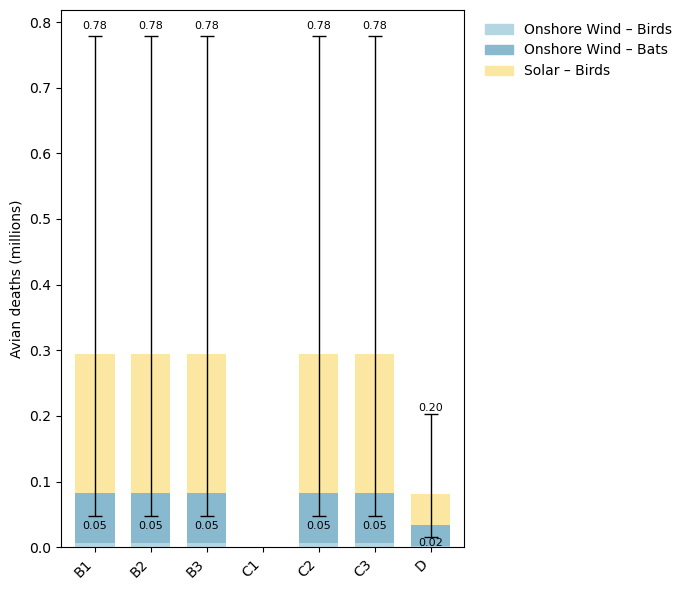

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ── assume cap_diff = df1[techs] - df0[techs] is already defined ──────────

# 1) Monte Carlo settings & pathways
np.random.seed(42)
n_sims   = 1000
pathways = [p for p in cap_diff.index if p != 'A']
n_paths  = len(pathways)

# 2) Prepare array [sim, pathway, species-tech]
samples = np.zeros((n_sims, n_paths, 3))
for s in range(n_sims):
    bird_on = np.random.gamma(0.20, 2.54)
    bat_on  = np.random.gamma(1.538, 4.160)
    s_rate  = np.random.lognormal(np.log(1.214), 1.409)

    onshore_cap = cap_diff.loc[pathways, 'Onshore Wind'].values
    solar_cap   = cap_diff.loc[pathways, 'Solar'].values

    samples[s, :, 0] = bird_on * onshore_cap
    samples[s, :, 1] = bat_on  * onshore_cap
    samples[s, :, 2] = s_rate  * solar_cap

# 3) Compute per-category means (as before) and total_per_sim
mean_vals = samples.mean(axis=0)  # shape (n_paths, 3)
mean_df   = pd.DataFrame(
    mean_vals,
    index=pathways,
    columns=['Onshore Bird','Onshore Bat','Solar Bird']
) / 1e6

total_per_sim = samples.sum(axis=2)  # shape (n_sims, n_paths)

# 3b) Compute trimmed percentiles (e.g., 2.5 and 97.5)
lower_bounds = np.percentile(total_per_sim, 5, axis=0) / 1e6
upper_bounds = np.percentile(total_per_sim, 95, axis=0) / 1e6
mean_total   = total_per_sim.mean(axis=0) / 1e6

lower_errors = mean_total - lower_bounds
upper_errors = upper_bounds - mean_total
yerr = np.vstack((lower_errors, upper_errors))  # shape (2, n_paths)

# 3c) Build a mask for everything except "C1"
mask = np.array(pathways) != 'C1'  # True for pathways ≠ "C1", False at index where pathway=="C1"

# 4) Plot stacked bar + error bars excluding "C1"
colors = {
    'Onshore Bird': '#B4D6E3',
    'Onshore Bat':  '#89B9CF',
    'Solar Bird':   '#FBE7A1'
}
legend_map = {
    'Onshore Bird': 'Onshore Wind – Birds',
    'Onshore Bat':  'Onshore Wind – Bats',
    'Solar Bird':   'Solar – Birds'
}

fig, ax = plt.subplots(figsize=(7,6))

# 4a) Stacked bars of means (all pathways)
mean_df.plot(
    kind='bar',
    stacked=True,
    color=[colors[c] for c in mean_df.columns],
    width=0.7,
    ax=ax
)

# 4b) Overlay error bars—but only for indices where mask == True
x       = np.arange(n_paths)
x_err   = x[mask]               # x-positions except C1
mean_err = mean_total[mask]     # mean_totals except C1
yerr_err = yerr[:, mask]        # y-errors except C1 (shape (2, sum(mask)))

ax.errorbar(
    x_err,
    mean_err,
    yerr=yerr_err,
    fmt='none',
    ecolor='black',
    capsize=5,
    linewidth=1.0
)

# 4c) Annotate trimmed bounds only for non-"C1" entries
label_offset = (upper_bounds - lower_bounds) * 0.01  # 5% offset for all pathways
for idx in np.where(mask)[0]:
    # idx is the integer index where pathway != "C1"
    xi  = x[idx]
    lb  = lower_bounds[idx]
    ub  = upper_bounds[idx]
    off = label_offset[idx]
    ax.text(xi, ub + off, f"{ub:.2f}", ha='center', va='bottom', fontsize=8)
    ax.text(xi, lb - off, f"{lb:.2f}", ha='center', va='top',    fontsize=8)

# 4d) Final formatting
ax.set_xticklabels(pathways, rotation=45, ha='right')
ax.set_ylabel('Avian deaths (millions)')

handles = [
    plt.matplotlib.patches.Patch(color=colors[c], label=legend_map[c])
    for c in mean_df.columns
]
ax.legend(
    handles=handles,
    loc='upper left',
    bbox_to_anchor=(1.02, 1),
    frameon=False
)

plt.tight_layout()
plt.savefig('avian_deaths.png', dpi=300,
            bbox_inches='tight', pad_inches=0.1)
plt.show()


In [32]:
(0.211828+0.076025+0.005851)*1e6

293703.99999999994

In [30]:
mean_df

,Onshore Bird,Onshore Bat,Solar Bird
B1,0.005851,0.076025,0.211828
B2,0.005851,0.076025,0.211828
B3,0.005851,0.076025,0.211828
C1,0.000000,0.000000,0.000000
C2,0.005851,0.076025,0.211828
C3,0.005851,0.076025,0.211828
D,0.002468,0.032076,0.046744
